In [32]:
"""
error_analysis.py

This script performs error analysis on result JSON files generated by any of the approaches.
It uses the shared analyze_errors() function from factchecker_base.
"""

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import os

# Save and Load Functions

In [12]:
def save_to_json(data, file_path):
    """
    Save a list of dictionaries to a JSON file.
    """
    try:
        with open(file_path, "w") as json_file:
            json.dump(data, json_file, indent=2)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving data to {file_path}: {e}")

def load_json(file_path):
    """
    Load a JSON file containing a list of dictionaries.
    """
    try:
        with open(file_path, "r") as json_file:
            data = json.load(json_file)
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return []


# Plot Functions

In [30]:
def accuracy(predictions):
    
    correct_predictions = sum(1 for p in predictions if p['true_response'] == p['predicted_response'])
    total_predictions = len(predictions)

    accuracy = (correct_predictions / total_predictions) * 100

    return (accuracy)

## Plot Misclassifications per categories

In [48]:
def calculate_misclassifications(predictions, categorised_claims, category_misclassifications):
    """
    Calculates the misclassification percentage for each category, based on the new structure where
    true_response is in the predictions.

    Args:
    - predictions (list of dicts): Predictions made by the model.
    - categorised_claims (list of dicts): Claims categorized under different labels.

    Returns:
    - dict: A dictionary with categories as keys and misclassification percentages as values.
    """
    # Initialize counters for total claims and misclassifications per category
    category_counts = {category: 0 for category in category_misclassifications}
    category_misclassifications = {category: 0 for category in category_misclassifications}

    for prediction in predictions:
        claim = prediction["claim"]
        true_response = prediction["true_response"]
        predicted_response = prediction["predicted_response"]
        
        # Find the claim in the categorised_claims
        claim_data = next((item for item in categorised_claims if item["claim"] == claim), None)
        
        if claim_data:
            # Check if the prediction is misclassified
            is_misclassified = true_response != predicted_response

            # Loop through each category in the claim and update misclassification counts
            for category in category_counts:
                if category in claim_data and claim_data[category]:
                    # If the claim is part of the category, update the counts
                    category_counts[category] += 1
                    if is_misclassified:
                        category_misclassifications[category] += 1

    # Calculate the percentage of misclassifications for each category
    category_percentages = {
        category: (category_misclassifications[category] / category_counts[category] * 100)
        if category_counts[category] > 0 else 0
        for category in category_counts
    }

    return category_percentages

In [14]:
def plot_misclassifications(category_percentages):
    """
    Plots the misclassification percentages for each category.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [28]:
def plot_misclassifications_with_overall_misclassification(category_percentages, predictions):
    """
    Plots the misclassification percentages for each category and adds a dashed horizontal line 
    representing the overall accuracy of the classifications.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    - predictions (list of dicts): Predictions made by the model.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())

    # Compute overall accuracy
    total_predictions = len(predictions)
    total_misclassifications = sum(1 for p in predictions if p["true_response"] != p["predicted_response"])
    overall_accuracy = total_misclassifications / total_predictions * 100

    # Plot histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r', alpha=0.7, label='Misclassification %')

    # Add horizontal line for overall accuracy
    ax.axhline(y=overall_accuracy, color='b', linestyle='dashed', linewidth=2, label=f'Overall Misclassification Rate: {overall_accuracy:.2f}%')

    # Labels and title
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot category co-occurences

In [15]:
def plot_category_cooccurrence(categorised_claims):
    # Extract all unique categories
    categories = set()
    for claim in categorised_claims:
        categories.update(claim.keys())
    categories.discard("ID")  # Remove non-category fields
    categories.discard("claim")
    
    # Initialize co-occurrence matrix
    category_list = sorted(categories)
    cooccurrence_matrix = pd.DataFrame(0, index=category_list, columns=category_list)
    
    # Populate co-occurrence matrix
    for claim in categorised_claims:
        active_categories = [cat for cat in category_list if claim.get(cat, False)]
        for i in range(len(active_categories)):
            for j in range(i, len(active_categories)):
                cooccurrence_matrix.loc[active_categories[i], active_categories[j]] += 1
                if i != j:
                    cooccurrence_matrix.loc[active_categories[j], active_categories[i]] += 1
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title("Category Co-occurrence Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

## Count claims per categories

In [57]:
def count_claims_per_category(categorised_claims):
    # Initialize a defaultdict to store counts for each category
    category_counts = defaultdict(int)
    
    # Loop through each claim in categorised_claims
    for claim_data in categorised_claims:
        # Loop through each key in the claim (excluding ID and claim text)
        for category, is_present in claim_data.items():
            # Only count if the category is a boolean and is True
            if category != "ID" and category != "claim" and is_present:
                category_counts[category] += 1
    
    return category_counts

def plot_category_counts(category_counts):
    # Create a bar plot for category counts
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    
    # Create the bar plot
    bars = plt.bar(categories, counts, color='skyblue')
    
    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Number of Claims')
    plt.title('Number of Claims per Category')
    plt.xticks(rotation=45, ha="right")
    
    # Annotate each bar with the count value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', va='bottom')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## Assess performance of two models

In [38]:
def plot_comparison(model_1_errors, model_2_errors, accuracy_model_1, accuracy_model_2):
    # Define categories (keys in the dictionaries)
    categories = list(model_1_errors.keys())
    
    # Extract error values from dictionaries
    model_1_values = list(model_1_errors.values())
    model_2_values = list(model_2_errors.values())
    
    # Create x positions for the bars
    x = np.arange(len(categories))
    
    # Set width of bars
    width = 0.35
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for both models
    bars_model_1 = ax.bar(x - width/2, model_1_values, width, label=f'Model 1 (Accuracy: {accuracy_model_1:.2f}%)')
    bars_model_2 = ax.bar(x + width/2, model_2_values, width, label=f'Model 2 (Accuracy: {accuracy_model_2:.2f}%)')
    
    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.set_title('Model Performance Comparison per Category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    
    # Add a legend
    ax.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()


# Plot

In [52]:
predictions_file_name_1 = "../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_html.json"
predictions_1 = load_json(predictions_file_name_1)

predictions_file_name_2 = "../docs/results/results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_markdown.json"
predictions_2 = load_json(predictions_file_name_2)

{'all': 15.393322014714206, 'none': 13.073784427065624, 'negate': 13.81615598885794, 'comparative': 14.620969103494852, 'ordinal': 13.747758517632994, 'unique': 13.327848621966268, 'superlative': 14.121663563004343, 'aggregation': 14.046242774566476}


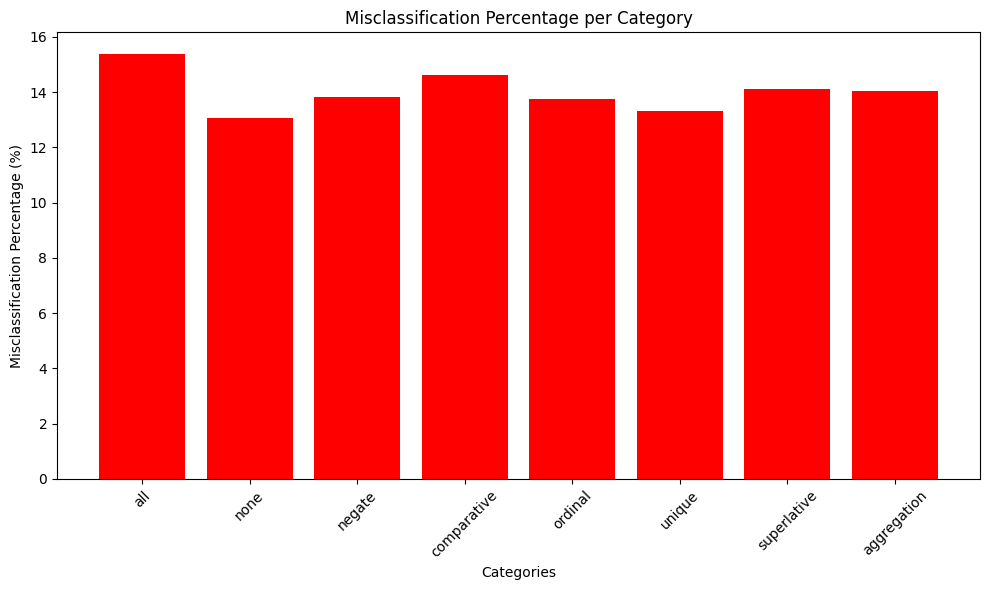

In [53]:
categorised_claims_file_name = "Error_Analysis/categorised_claims_mistral.json"
categorised_claims = load_json(categorised_claims_file_name)

their_category_misclassifications = { 
        "all": 0, "none": 0, "negate": 0, "comparative": 0, 
        "ordinal": 0, "unique": 0, "superlative": 0, "aggregation": 0
    }

our_category_misclassifications = {
    "single_attribute_verification": 0,
    "multi_attribute_conjunction": 0,
    "negation_absence_check": 0,
    "numerical_threshold_check": 0,
    "membership_association": 0,
    "aggregation_computation": 0,
    "record_existence": 0,
    "comparative_analysis": 0,
    "conditional_logic": 0
    }

our_category_misclassifications_bis = {
    "unclear_or_noisy_language": 0,
    "numerical_reasoning": 0,
    "multistep_logic": 0,
    "negation": 0
}

category_percentages = calculate_misclassifications(predictions_1, categorised_claims, their_category_misclassifications)
print(category_percentages)
plot_misclassifications(category_percentages)

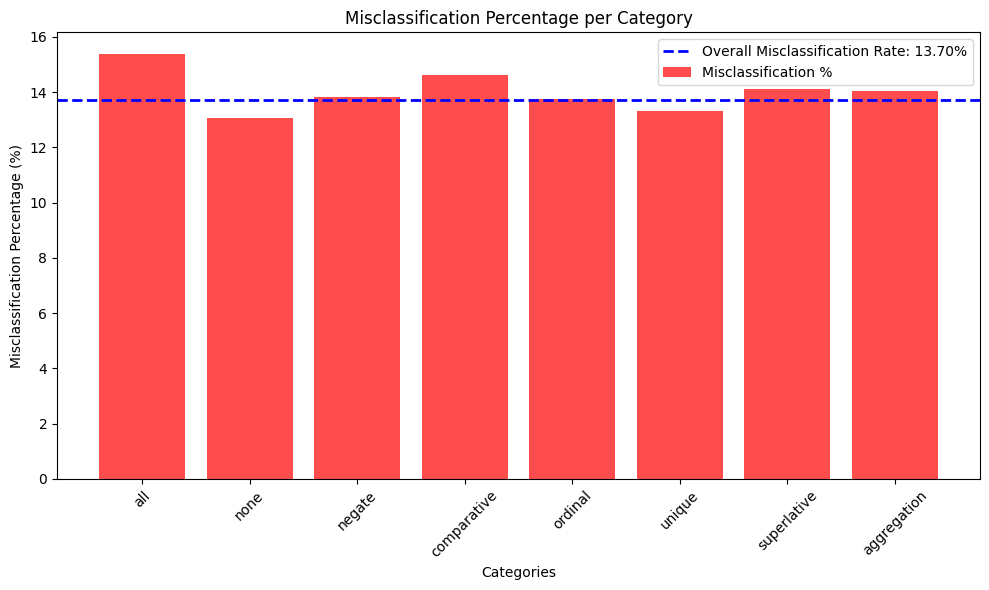

In [55]:
plot_misclassifications_with_overall_misclassification(predictions=predictions_1, category_percentages=category_percentages)

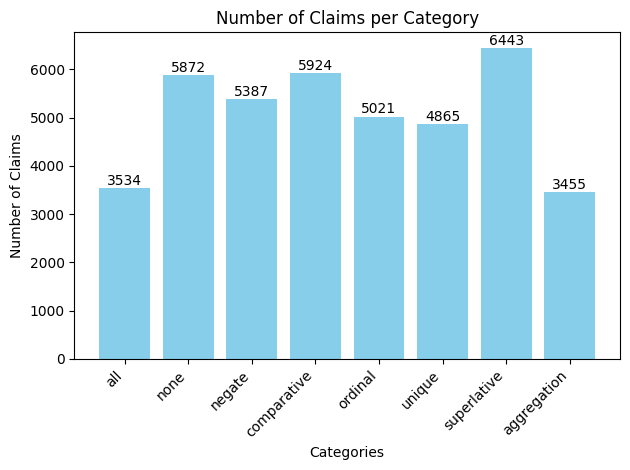

In [58]:
category_counts = count_claims_per_category(categorised_claims)
plot_category_counts(category_counts)

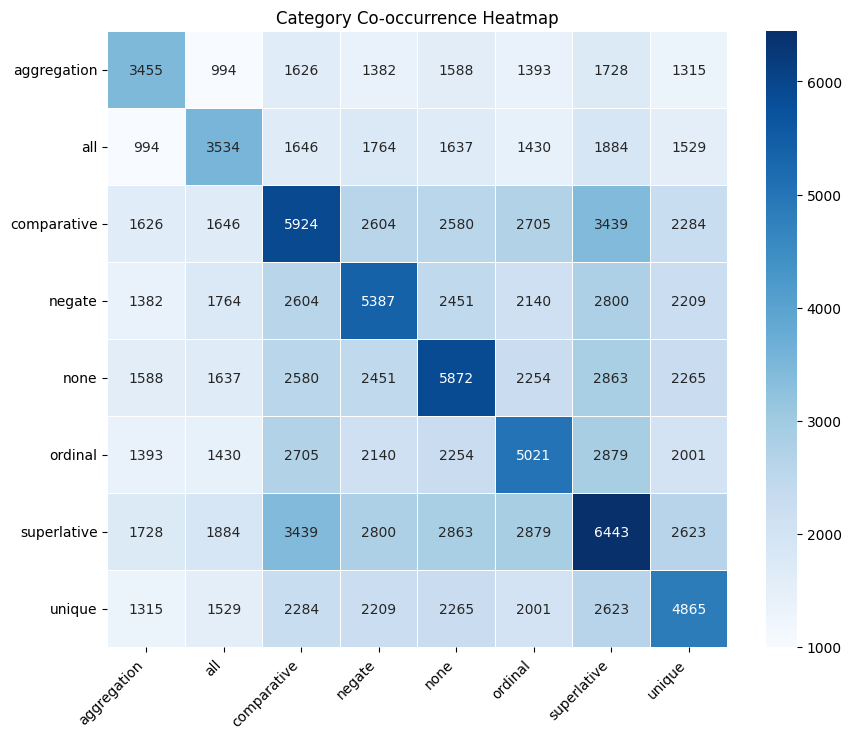

In [59]:
plot_category_cooccurrence(categorised_claims)

{'all': 15.393322014714206, 'none': 13.073784427065624, 'negate': 13.81615598885794, 'comparative': 14.620969103494852, 'ordinal': 13.747758517632994, 'unique': 13.327848621966268, 'superlative': 14.121663563004343, 'aggregation': 14.046242774566476}
{'all': 37.8324844368987, 'none': 34.56307378442707, 'negate': 39.27576601671309, 'comparative': 38.105689684281614, 'ordinal': 37.118947997609084, 'unique': 36.30193336075689, 'superlative': 37.78708876474239, 'aggregation': 35.664739884393065}


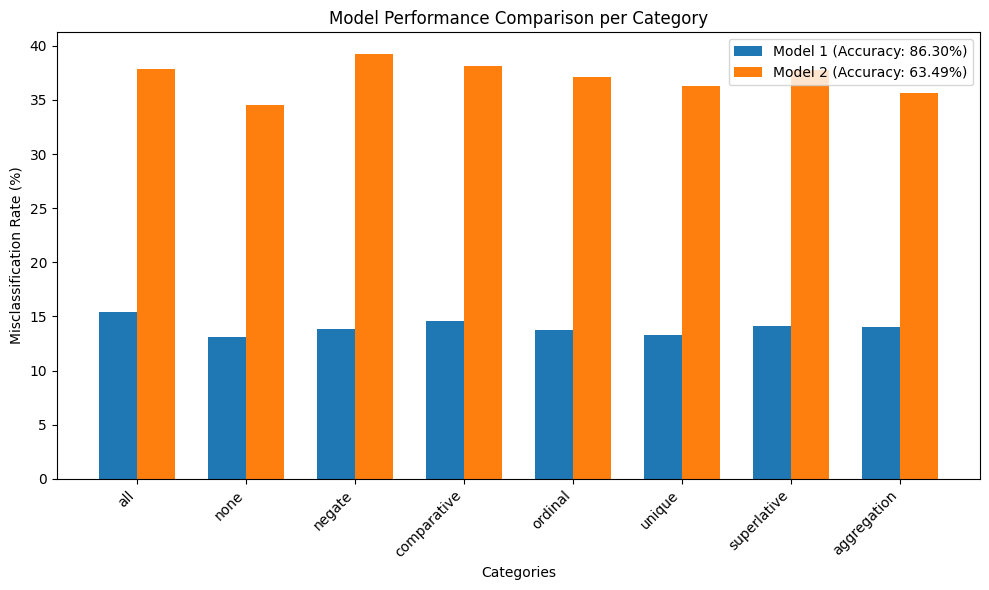

In [61]:
category_percentages_1 = calculate_misclassifications(predictions_1, categorised_claims, their_category_misclassifications)
category_percentages_2 = calculate_misclassifications(predictions_2, categorised_claims, their_category_misclassifications)

accuracy_model_1 = accuracy(predictions_1)
accuracy_model_2 = accuracy(predictions_2)

print(category_percentages_1)
print(category_percentages_2)

plot_comparison(category_percentages_1, category_percentages_2, accuracy_model_1, accuracy_model_2)

# Helper functions

In [ ]:
def split_claims(claims_list):
    misclassified = []
    correctly_classified = []

    for claim_data in claims_list:
        if claim_data["predicted_response"] != claim_data["true_response"]:
            misclassified.append(claim_data["claim"])
        else:
            correctly_classified.append(claim_data["claim"])

    return misclassified[:50], correctly_classified[:50]

# Example usage
misclassified_claims, correctly_classified_claims = split_claims(predictions_1)
for m in misclassified_claims:
    print(m)
    print()


print("\n\nHere are correctly classified claims:\n\n")

for c in correctly_classified_claims:
    print(c)
    print()

tony lema do not win in the pga championship

the only tournament that tony lema win in be the open championship

jonathan legear score 4 more goal than matías suárez , the next highest rank player in the belgian first dvision a league who play in the belgian cup

though 4 player from belgian first division a be in the top 19 scorer , the top scorer (matias suarez) have 8 fewer goal than mbark boussoufa , who have 11 goal

jelle van damme score 3 time as much as each of the other 2 player in the uefa champion league tournament

rafael márquez score 3 goal in his career at international friendly competition

2000 be the only year rafael márquez score more than 1 goal in international competition

mexico only lose 1 time in international competition when rafael márquez score a goal

the brewer lose in the game that have the biggest attendance in the month of august

the brewer win the game which have the lowest attendance of the month

only round 3 be not list 2 time

2 player be draft i

In [35]:
def find_files_with_max_elements(path_name):
    max_elements = 0
    files_with_max_elements = []

    # Iterate through all files in the folder
    for filename in os.listdir(path_name):
        if filename.endswith('.json'):
            file_path = os.path.join(path_name, filename)
            
            # Open the JSON file and load its content
            with open(file_path, 'r') as file:
                data = json.load(file)
                
                # Check the number of objects (elements) in the list
                num_elements = len(data)
                
                # Update max_elements and the corresponding filenames
                if num_elements > max_elements:
                    max_elements = num_elements
                    files_with_max_elements = [filename]
                elif num_elements == max_elements:
                    files_with_max_elements.append(filename)

    return files_with_max_elements

# Example usage
path_name = '../docs/results'  # Replace with the path to your folder
files = find_files_with_max_elements(path_name)
print("Files with the maximum number of elements:")
for file in files:
    print(file)

Files with the maximum number of elements:
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_html.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_markdown.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_naturalized.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_html.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_json.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_markdown.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_naturalized.json
results_with_cells_mistral:latest_test_examples_1695_zero_shot_html.json
results_with_cells_mistral:latest_test_examples_1695_zero_shot_json.json
results_with_cells_mistral:latest_test_examples_1695_zero_shot_markdown.json
results_with_cells_mist